In [1]:
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium
import contextily as ctx
import scipy.stats as stats
import scipy.interpolate

In [2]:
#Define variable to store current year
#curr_y = datetime.now().year
curr_y = pd.to_datetime("today").year
curr_y

2022

In [3]:
sites_fn = 'snotel_conus_baker.json'
snwd_pkl_fn = 'snotel_snwd_d_baker.pkl'
wteq_pkl_fn = 'snotel_wteq_d_baker.pkl'

In [4]:
#Note: geojson uses integer index, so need the `set_index` below
sites_gdf_all = gpd.read_file(sites_fn).set_index('index')
sites_gdf_all.head()

,code,name,network,elevation_m,site_property,geometry
index,,,,,,
SNOTEL:910_WA_SNTL,910_WA_SNTL,Elbow Lake,SNOTEL,926.591980,"{'county': 'Whatcom', 'state': 'Washington', '...",POINT (-121.90893 48.69092)
SNOTEL:999_WA_SNTL,999_WA_SNTL,Marten Ridge,SNOTEL,1072.895996,"{'county': 'Whatcom', 'state': 'Washington', '...",POINT (-121.69823 48.76292)
SNOTEL:1011_WA_SNTL,1011_WA_SNTL,MF Nooksack,SNOTEL,1514.855957,"{'county': 'Whatcom', 'state': 'Washington', '...",POINT (-121.92951 48.82453)
SNOTEL:909_WA_SNTL,909_WA_SNTL,Wells Creek,SNOTEL,1228.343994,"{'county': 'Whatcom', 'state': 'Washington', '...",POINT (-121.78976 48.86610)


In [5]:
sites_gdf_proj = sites_gdf_all.to_crs(32610)

In [6]:
snwd_df = pd.read_pickle(snwd_pkl_fn)
wteq_df = pd.read_pickle(wteq_pkl_fn)

In [7]:
baker_glaciers = gpd.read_file('baker_glacier.json')
baker_glaciers = baker_glaciers.to_crs(32610)

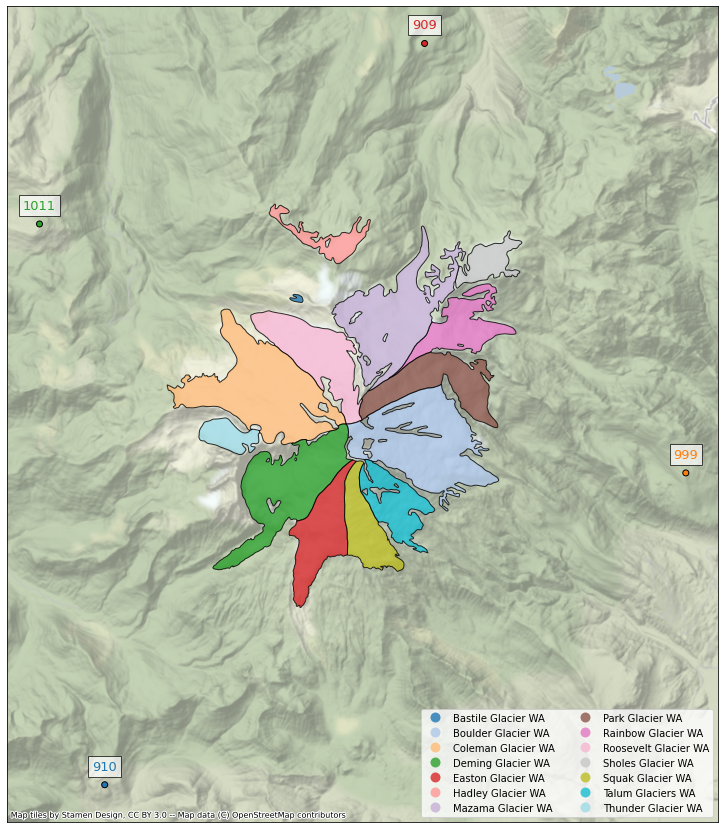

In [122]:
color_list = ['C%i' % i for i in range(len(sites_gdf_proj))]

f, ax = plt.subplots(figsize=(15,15))
sites_gdf_proj.plot(facecolor=color_list, edgecolor='k', ax=ax)
for x, y, label, c in zip(sites_gdf_proj.geometry.x, sites_gdf_proj.geometry.y, sites_gdf_proj.code.str.split('_').str[0], color_list):
    ax.annotate(label, xy=(x,y), xytext=(0, 15), ha='center', textcoords="offset points", color=c, fontsize=13, bbox=dict(boxstyle="square",fc='w',alpha=0.7))
ctx.add_basemap(ax=ax, crs=sites_gdf_proj.crs, source=ctx.providers.Stamen.Terrain, alpha=0.7)
ax.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)

baker_glaciers.plot(cmap='tab20', edgecolor='k', alpha=0.8, ax=ax, column=baker_glaciers.Name, legend=True, legend_kwds={'loc': 'lower right', 'ncol': 2})

#f.savefig('snotel_rgi.jpg', bbox_inches='tight', dpi=150);

In [9]:
snwd_df = pd.read_pickle(snwd_pkl_fn)
snwd_df = snwd_df.dropna(thresh=4)

In [10]:
wteq_df = pd.read_pickle(wteq_pkl_fn)
#wteq_df = wteq_df.dropna(thresh=4)

In [12]:
#Add DOY and DOWY column
#Need to revisit for leap year support
def add_dowy(df, col=None):
    if col is None:
        df['doy'] = df.index.dayofyear
    else:
        df['doy'] = df[col].dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365
    #df['dowy'] = (df['doy'].index - pd.DateOffset(months=9)).dayofyear

In [123]:
#Source code: https://bmorph.readthedocs.io/en/latest/_modules/bmorph/evaluation/plotting.html#calc_water_year
def calc_water_year(df: pd.DataFrame):
    """Calculates the water year.

    Parameters
    ----------
    df : pandas.DataFrame
        Flow timeseries with a DataTimeIndex.

    Returns
    -------
    pandas.DataFrame.index
        A pandas.DataFrame index grouped by water year.

    """
    return df.index.year + (df.index.month >= 10).astype(int)

In [14]:
add_dowy(snwd_df)

In [15]:
snwd_df['wy'] = calc_water_year(snwd_df)

In [16]:
snwd_df.head()

,SNOTEL:910_WA_SNTL,SNOTEL:999_WA_SNTL,SNOTEL:1011_WA_SNTL,SNOTEL:909_WA_SNTL,doy,dowy,wy
datetime,,,,,,,
2006-07-12 00:00:00+00:00,0.0,0.0,0.0,0.0,193,285,2006
2006-07-13 00:00:00+00:00,0.0,0.0,0.0,0.0,194,286,2006
2006-07-14 00:00:00+00:00,0.0,0.0,0.0,0.0,195,287,2006
2006-07-15 00:00:00+00:00,0.0,0.0,0.0,0.0,196,288,2006
2006-07-16 00:00:00+00:00,0.0,0.0,0.0,0.0,197,289,2006


In [17]:
add_dowy(wteq_df)

In [18]:
wteq_df['wy'] = calc_water_year(wteq_df)

In [19]:
#wteq_df = wteq_df[wteq_df['wy'] != 2006] 
wteq_df = wteq_df[wteq_df['wy'] != 2022] 

wteq_df.head()

,SNOTEL:910_WA_SNTL,SNOTEL:999_WA_SNTL,SNOTEL:1011_WA_SNTL,SNOTEL:909_WA_SNTL,doy,dowy,wy
datetime,,,,,,,
1995-08-28 00:00:00+00:00,0.0,NaN,NaN,NaN,240,332,1995
1995-08-29 00:00:00+00:00,0.0,NaN,NaN,NaN,241,333,1995
1995-08-30 00:00:00+00:00,0.0,NaN,NaN,NaN,242,334,1995
1995-08-31 00:00:00+00:00,0.0,NaN,NaN,NaN,243,335,1995
1995-09-01 00:00:00+00:00,0.0,NaN,NaN,NaN,244,336,1995


## Preliminary Summary of SWE data per station

In [20]:
stat_list = ['count','min','max','mean','std','median','mad']

In [21]:
nyears = (wteq_df.index.max() - wteq_df.index.min()).days/365.25

In [22]:
wteq_910 = wteq_df[['SNOTEL:910_WA_SNTL', 'dowy', 'wy']].copy()
wteq_910_doy_stats = wteq_910.groupby('dowy').agg(stat_list)['SNOTEL:910_WA_SNTL']

wteq_999 = wteq_df[['SNOTEL:999_WA_SNTL', 'dowy', 'wy']].copy()
wteq_999_doy_stats = wteq_999.groupby('dowy').agg(stat_list)['SNOTEL:999_WA_SNTL']

wteq_1011 = wteq_df[['SNOTEL:1011_WA_SNTL', 'dowy', 'wy']].copy()
wteq_1011_doy_stats = wteq_1011.groupby('dowy').agg(stat_list)['SNOTEL:1011_WA_SNTL']

wteq_909 = wteq_df[['SNOTEL:909_WA_SNTL', 'dowy', 'wy']].copy()
wteq_909_doy_stats = wteq_909.groupby('dowy').agg(stat_list)['SNOTEL:909_WA_SNTL']

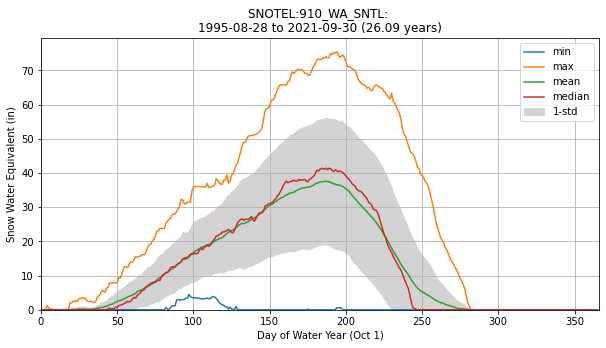

In [23]:
f,ax = plt.subplots(figsize=(10,5))

for stat in ['min','max','mean','median']:
    ax.plot(wteq_910_doy_stats.index, wteq_910_doy_stats[stat], label=stat)

ax.fill_between(wteq_910_doy_stats.index, wteq_910_doy_stats['mean'] - wteq_910_doy_stats['std'], wteq_910_doy_stats['mean'] + wteq_910_doy_stats['std'], \
                color='lightgrey', label='1-std')

title = f'SNOTEL:910_WA_SNTL: \n{wteq_910.index.min().date()} to {wteq_910.index.max().date()} ({nyears:.2f} years)'

ax.set_title(title)
ax.set_xlabel('Day of Water Year (Oct 1)')
ax.set_ylabel('Snow Water Equivalent (in)')
ax.grid()
ax.legend()
ax.set_xlim(0,366)
ax.set_ylim(bottom=0);

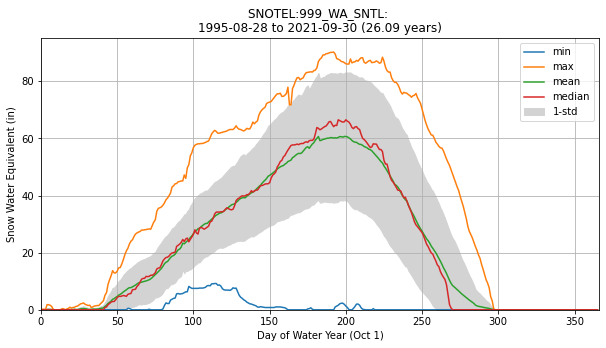

In [24]:
f,ax = plt.subplots(figsize=(10,5))

for stat in ['min','max','mean','median']:
    ax.plot(wteq_999_doy_stats.index, wteq_999_doy_stats[stat], label=stat)

ax.fill_between(wteq_999_doy_stats.index, wteq_999_doy_stats['mean'] - wteq_999_doy_stats['std'], wteq_999_doy_stats['mean'] + wteq_999_doy_stats['std'], \
                color='lightgrey', label='1-std')

title = f'SNOTEL:999_WA_SNTL: \n{wteq_999.index.min().date()} to {wteq_999.index.max().date()} ({nyears:.2f} years)'

ax.set_title(title)
ax.set_xlabel('Day of Water Year (Oct 1)')
ax.set_ylabel('Snow Water Equivalent (in)')
ax.grid()
ax.legend()
ax.set_xlim(0,366)
ax.set_ylim(bottom=0);

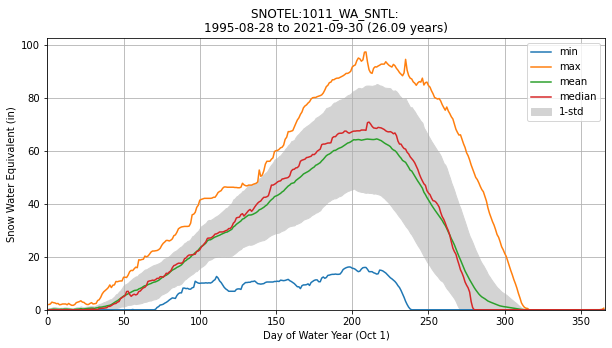

In [25]:
f,ax = plt.subplots(figsize=(10,5))

for stat in ['min','max','mean','median']:
    ax.plot(wteq_1011_doy_stats.index, wteq_1011_doy_stats[stat], label=stat)

ax.fill_between(wteq_1011_doy_stats.index, wteq_1011_doy_stats['mean'] - wteq_1011_doy_stats['std'], wteq_1011_doy_stats['mean'] + wteq_1011_doy_stats['std'], \
                color='lightgrey', label='1-std')

title = f'SNOTEL:1011_WA_SNTL: \n{wteq_1011.index.min().date()} to {wteq_1011.index.max().date()} ({nyears:.2f} years)'

ax.set_title(title)
ax.set_xlabel('Day of Water Year (Oct 1)')
ax.set_ylabel('Snow Water Equivalent (in)')
ax.grid()
ax.legend()
ax.set_xlim(0,366)
ax.set_ylim(bottom=0);

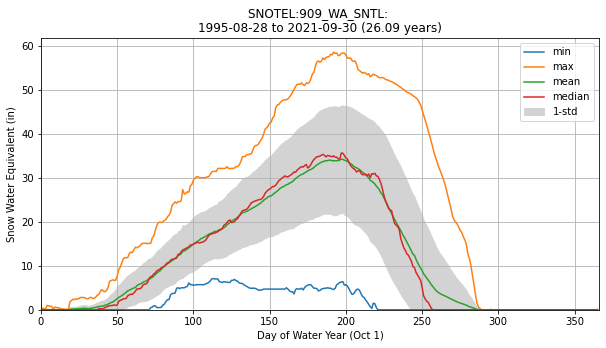

In [26]:
f,ax = plt.subplots(figsize=(10,5))

for stat in ['min','max','mean','median']:
    ax.plot(wteq_909_doy_stats.index, wteq_909_doy_stats[stat], label=stat)

ax.fill_between(wteq_909_doy_stats.index, wteq_909_doy_stats['mean'] - wteq_909_doy_stats['std'], wteq_909_doy_stats['mean'] + wteq_909_doy_stats['std'], \
                color='lightgrey', label='1-std')

title = f'SNOTEL:909_WA_SNTL: \n{wteq_909.index.min().date()} to {wteq_909.index.max().date()} ({nyears:.2f} years)'

ax.set_title(title)
ax.set_xlabel('Day of Water Year (Oct 1)')
ax.set_ylabel('Snow Water Equivalent (in)')
ax.grid()
ax.legend()
ax.set_xlim(0,366)
ax.set_ylim(bottom=0);

In [27]:
#Drop all missing values
wteq_1011 = wteq_1011.dropna()
wteq_999 = wteq_999.dropna()
wteq_909 = wteq_909.dropna()
wteq_910 = wteq_910.dropna()

In [33]:
#Filtering out incomplete years
wteq_1011 = wteq_1011[wteq_1011['wy'] != 2003] 
wteq_909 = wteq_909[wteq_909['wy'] != 1995]
wteq_910 = wteq_910[wteq_910['wy'] != 1995]
wteq_999 = wteq_999[wteq_999['wy'] != 2006]

In [34]:
#The dowy calc above didn't account for leap year - not important for this particular analysis
#Recognizing 9-30 as the previous water year
wteq_1011.at['2004-09-30', 'dowy'] = 366
wteq_1011.at['2008-09-30', 'dowy'] = 366
wteq_1011.at['2012-09-30', 'dowy'] = 366
wteq_1011.at['2016-09-30', 'dowy'] = 366
wteq_1011.at['2020-09-30', 'dowy'] = 366

In [35]:
wteq_909.at['1996-09-30', 'dowy'] = 366
wteq_909.at['2000-09-30', 'dowy'] = 366
wteq_909.at['2004-09-30', 'dowy'] = 366
wteq_909.at['2008-09-30', 'dowy'] = 366
wteq_909.at['2012-09-30', 'dowy'] = 366
wteq_909.at['2016-09-30', 'dowy'] = 366
wteq_909.at['2020-09-30', 'dowy'] = 366

In [36]:
wteq_910.at['1996-09-30', 'dowy'] = 366
wteq_910.at['2000-09-30', 'dowy'] = 366
wteq_910.at['2004-09-30', 'dowy'] = 366
wteq_910.at['2008-09-30', 'dowy'] = 366
wteq_910.at['2012-09-30', 'dowy'] = 366
wteq_910.at['2016-09-30', 'dowy'] = 366
wteq_910.at['2020-09-30', 'dowy'] = 366

In [37]:
wteq_999.at['2008-09-30', 'dowy'] = 366
wteq_999.at['2012-09-30', 'dowy'] = 366
wteq_999.at['2016-09-30', 'dowy'] = 366
wteq_999.at['2020-09-30', 'dowy'] = 366

In [41]:
#Finding the last day of SWE = 0 during accumulation period (start of annual snowpack)
def wteq_start(df):
    col = df.columns[0]
    idx_min = df.groupby(['wy'])[col].transform(min) == df[col]
    wteq_start = df[df['dowy'] < 100][idx_min]
    wteq_start = wteq_start.drop_duplicates(subset=[col, 'wy'], keep='last')
    return wteq_start

In [42]:
#Finding the first day of SWE = 0 during melt period (end of annual snowpack)
def wteq_end(df):
    col = df.columns[0]
    idx_min = df.groupby(['wy'])[col].transform(min) == df[col]
    wteq_end = df[df['dowy'] > 180][idx_min]
    wteq_end = wteq_end.drop_duplicates(subset=[col, 'wy'], keep='first')
    return wteq_end

In [43]:
#Finding the day of peak SWE
def wteq_peak(df):
    col = df.columns[0]
    idx_max = df.groupby(['wy'])[col].transform(max) == df[col]
    wteq_peak = df[idx_max]
    wteq_peak = wteq_peak.drop_duplicates(subset=[col, 'wy'], keep='last')
    return wteq_peak

In [48]:
start_1011 = wteq_start(wteq_1011)
peak_1011 = wteq_peak(wteq_1011)
end_1011 = wteq_end(wteq_1011)

/tmp/ipykernel_140/2883204768.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wteq_start = df[df['dowy'] < 100][idx_min]


In [45]:
start_909 = wteq_start(wteq_909)
peak_909 = wteq_peak(wteq_909)
end_909 = wteq_end(wteq_909)

/tmp/ipykernel_140/2883204768.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wteq_start = df[df['dowy'] < 100][idx_min]


In [46]:
start_910 = wteq_start(wteq_910)
peak_910 = wteq_peak(wteq_910)
end_910 = wteq_end(wteq_910)

/tmp/ipykernel_140/2883204768.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wteq_start = df[df['dowy'] < 100][idx_min]


In [47]:
start_999 = wteq_start(wteq_999)
peak_999 = wteq_peak(wteq_999)
end_999 = wteq_end(wteq_999)

/tmp/ipykernel_140/2883204768.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wteq_start = df[df['dowy'] < 100][idx_min]


### Start of Snowpack Stats

In [105]:
x = start_1011.wy    # using x for shorthand below
y = start_1011.dowy  # using y for shorthand below

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y)

print('B0 : {}'.format(np.round(intercept,4)))
print('B1 : {}'.format(np.round(slope,4)))

print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr : {}'.format(np.round(stderr,3)))

B0 : -1169.5026
B1 : 0.5996
R^2 : 0.109
R : 0.329
stderr : 0.43


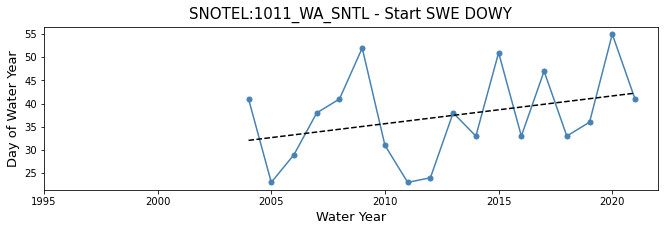

In [106]:
station = start_1011.columns[0]

x1 = np.linspace(x.min(),x.max(),2)
y1 = slope*x1 + intercept

f, ax = plt.subplots(figsize=(11,3))
plt.plot(x,y,'steelblue', linestyle='-', marker='.', markersize=10)
plt.plot(x1,y1,'k--')
plt.title(f'{station} - Start SWE DOWY', fontsize=15, y=1.01)

plt.xlim(1995, 2022)

plt.xlabel('Water Year', fontsize=13, labelpad=4)
plt.ylabel('Day of Water Year', fontsize=13, labelpad=4);

In [71]:
x = start_909.wy    # using x for shorthand below
y = start_909.dowy  # using y for shorthand below

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y)

print('B0 : {}'.format(np.round(intercept,4)))
print('B1 : {}'.format(np.round(slope,4)))

print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr : {}'.format(np.round(stderr,3)))

B0 : 152.2513
B1 : -0.0547
R^2 : 0.001
R : -0.037
stderr : 0.303


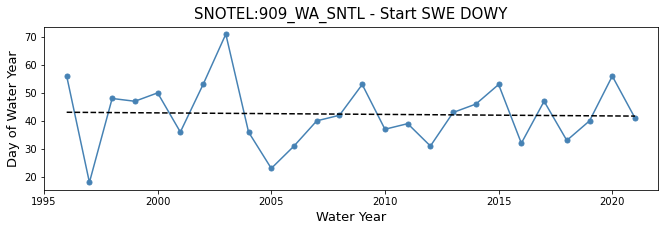

In [72]:
station = start_909.columns[0]

x1 = np.linspace(x.min(),x.max(),2)
y1 = slope*x1 + intercept

f, ax = plt.subplots(figsize=(11,3))
plt.plot(x,y,'steelblue', linestyle='-', marker='.', markersize=10)
plt.plot(x1,y1,'k--')
plt.title(f'{station} - Start SWE DOWY', fontsize=15, y=1.01)

plt.xlim(1995, 2022)

#plt.xticks(x)
plt.xlabel('Water Year', fontsize=13, labelpad=4)
plt.ylabel('Day of Water Year', fontsize=13, labelpad=4);

In [73]:
x = start_910.wy    # using x for shorthand below
y = start_910.dowy  # using y for shorthand below

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y)

print('B0 : {}'.format(np.round(intercept,4)))
print('B1 : {}'.format(np.round(slope,4)))

print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr : {}'.format(np.round(stderr,3)))

B0 : -801.8954
B1 : 0.4236
R^2 : 0.045
R : 0.212
stderr : 0.398


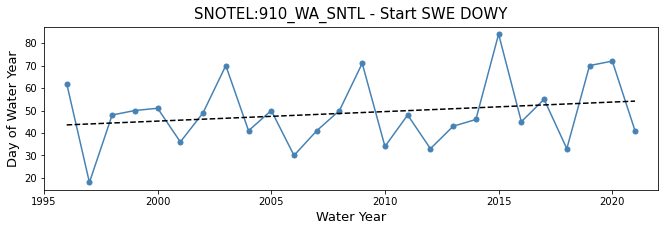

In [74]:
station = start_910.columns[0]

x1 = np.linspace(x.min(),x.max(),2)
y1 = slope*x1 + intercept

f, ax = plt.subplots(figsize=(11,3))
plt.plot(x,y,'steelblue', linestyle='-', marker='.', markersize=10)
plt.plot(x1,y1,'k--')
plt.title(f'{station} - Start SWE DOWY', fontsize=15, y=1.01)

plt.xlim(1995, 2022)

#plt.xticks(x)
plt.xlabel('Water Year', fontsize=13, labelpad=4)
plt.ylabel('Day of Water Year', fontsize=13, labelpad=4);

In [75]:
x = start_999.wy    # using x for shorthand below
y = start_999.dowy  # using y for shorthand below

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y)

print('B0 : {}'.format(np.round(intercept,4)))
print('B1 : {}'.format(np.round(slope,4)))

print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr : {}'.format(np.round(stderr,3)))

B0 : -1880.0857
B1 : 0.9571
R^2 : 0.072
R : 0.268
stderr : 0.956


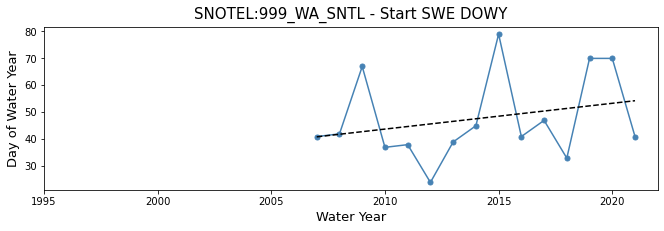

In [76]:
station = start_999.columns[0]

x1 = np.linspace(x.min(),x.max(),2)
y1 = slope*x1 + intercept

f, ax = plt.subplots(figsize=(11,3))
plt.plot(x,y,'steelblue', linestyle='-', marker='.', markersize=10)
plt.plot(x1,y1,'k--')
plt.title(f'{station} - Start SWE DOWY', fontsize=15, y=1.01)

plt.xlim(1995, 2022)

#plt.xticks(x)
plt.xlabel('Water Year', fontsize=13, labelpad=4)
plt.ylabel('Day of Water Year', fontsize=13, labelpad=4);

### Day of Peak SWE Stats

In [107]:
x = peak_1011.wy    # using x for shorthand below
y = peak_1011.dowy  # using y for shorthand below

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y)

print('B0 : {}'.format(np.round(intercept,4)))
print('B1 : {}'.format(np.round(slope,4)))

print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr : {}'.format(np.round(stderr,3)))

B0 : 1616.6398
B1 : -0.6976
R^2 : 0.1
R : -0.316
stderr : 0.523


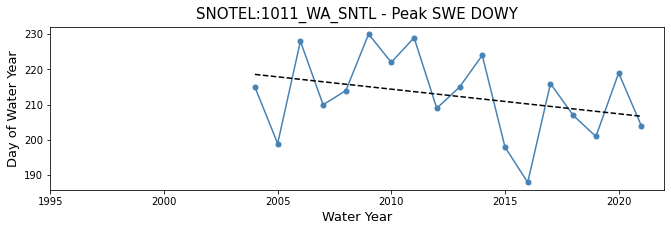

In [108]:
station = peak_1011.columns[0]

x1 = np.linspace(x.min(),x.max(),2)
y1 = slope*x1 + intercept

f, ax = plt.subplots(figsize=(11,3))
plt.plot(x,y,'steelblue', linestyle='-', marker='.', markersize=10)
plt.plot(x1,y1,'k--')
plt.title(f'{station} - Peak SWE DOWY', fontsize=15, y=1.01)

plt.xlim(1995, 2022)

#plt.xticks(x)
plt.xlabel('Water Year', fontsize=13, labelpad=4)
plt.ylabel('Day of Water Year', fontsize=13, labelpad=4);

In [80]:
x = peak_909.wy    # using x for shorthand below
y = peak_909.dowy  # using y for shorthand below

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y)

print('B0 : {}'.format(np.round(intercept,4)))
print('B1 : {}'.format(np.round(slope,4)))

print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr : {}'.format(np.round(stderr,3)))

B0 : 244.2964
B1 : -0.0263
R^2 : 0.0
R : -0.011
stderr : 0.5


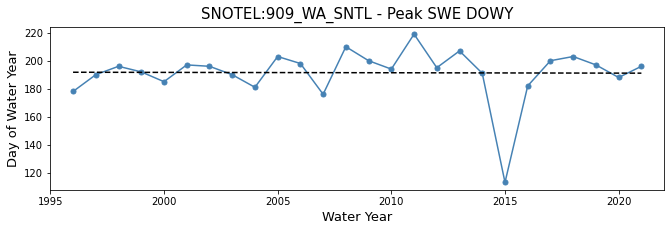

In [81]:
station = peak_909.columns[0]

x1 = np.linspace(x.min(),x.max(),2)
y1 = slope*x1 + intercept

f, ax = plt.subplots(figsize=(11,3))
plt.plot(x,y,'steelblue', linestyle='-', marker='.', markersize=10)
plt.plot(x1,y1,'k--')
plt.title(f'{station} - Peak SWE DOWY', fontsize=15, y=1.01)

plt.xlim(1995, 2022)

#plt.xticks(x)
plt.xlabel('Water Year', fontsize=13, labelpad=4)
plt.ylabel('Day of Water Year', fontsize=13, labelpad=4);

In [82]:
x = peak_910.wy    # using x for shorthand below
y = peak_910.dowy  # using y for shorthand below

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y)

print('B0 : {}'.format(np.round(intercept,4)))
print('B1 : {}'.format(np.round(slope,4)))

print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr : {}'.format(np.round(stderr,3)))

B0 : -354.0728
B1 : 0.266
R^2 : 0.009
R : 0.094
stderr : 0.574


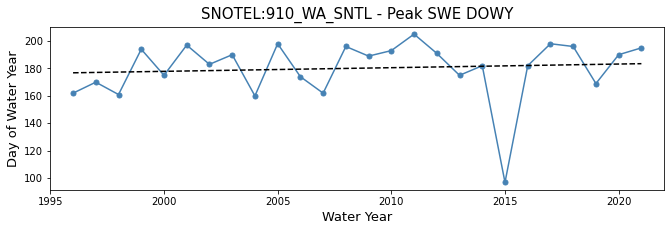

In [83]:
station = peak_910.columns[0]

x1 = np.linspace(x.min(),x.max(),2)
y1 = slope*x1 + intercept

f, ax = plt.subplots(figsize=(11,3))
plt.plot(x,y,'steelblue', linestyle='-', marker='.', markersize=10)
plt.plot(x1,y1,'k--')
plt.title(f'{station} - Peak SWE DOWY', fontsize=15, y=1.01)

plt.xlim(1995, 2022)

#plt.xticks(x)
plt.xlabel('Water Year', fontsize=13, labelpad=4)
plt.ylabel('Day of Water Year', fontsize=13, labelpad=4);

In [84]:
x = peak_999.wy    # using x for shorthand below
y = peak_999.dowy  # using y for shorthand below

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y)

print('B0 : {}'.format(np.round(intercept,4)))
print('B1 : {}'.format(np.round(slope,4)))

print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr : {}'.format(np.round(stderr,3)))

B0 : 731.3976
B1 : -0.2679
R^2 : 0.002
R : -0.048
stderr : 1.551


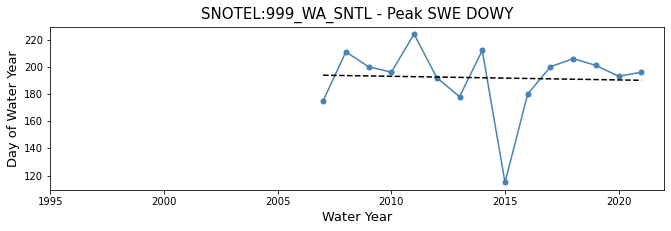

In [85]:
station = peak_999.columns[0]

x1 = np.linspace(x.min(),x.max(),2)
y1 = slope*x1 + intercept

f, ax = plt.subplots(figsize=(11,3))
plt.plot(x,y,'steelblue', linestyle='-', marker='.', markersize=10)
plt.plot(x1,y1,'k--')
plt.title(f'{station} - Peak SWE DOWY', fontsize=15, y=1.01)

plt.xlim(1995, 2022)

#plt.xticks(x)
plt.xlabel('Water Year', fontsize=13, labelpad=4)
plt.ylabel('Day of Water Year', fontsize=13, labelpad=4);

### End of Peak SWE Stats

In [109]:
x = end_1011.wy    # using x for shorthand below
y = end_1011.dowy  # using y for shorthand below

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y)

print('B0 : {}'.format(np.round(intercept,4)))
print('B1 : {}'.format(np.round(slope,4)))

print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr : {}'.format(np.round(stderr,3)))

B0 : 504.2136
B1 : -0.1125
R^2 : 0.001
R : -0.032
stderr : 0.871


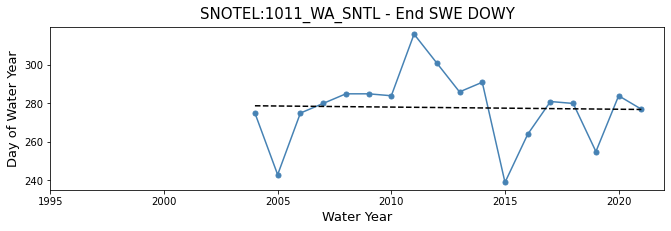

In [110]:
station = end_1011.columns[0]

x1 = np.linspace(x.min(),x.max(),2)
y1 = slope*x1 + intercept

f, ax = plt.subplots(figsize=(11,3))
plt.plot(x,y,'steelblue', linestyle='-', marker='.', markersize=10)
plt.plot(x1,y1,'k--')
plt.title(f'{station} - End SWE DOWY', fontsize=15, y=1.01)

plt.xlim(1995, 2022)

#plt.xticks(x)
plt.xlabel('Water Year', fontsize=13, labelpad=4)
plt.ylabel('Day of Water Year', fontsize=13, labelpad=4);

In [88]:
x = end_909.wy    # using x for shorthand below
y = end_909.dowy  # using y for shorthand below

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y)

print('B0 : {}'.format(np.round(intercept,4)))
print('B1 : {}'.format(np.round(slope,4)))

print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr : {}'.format(np.round(stderr,3)))

B0 : 330.9179
B1 : -0.0376
R^2 : 0.0
R : -0.018
stderr : 0.433


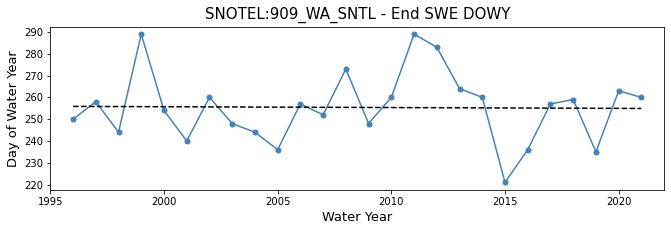

In [89]:
station = peak_909.columns[0]

x1 = np.linspace(x.min(),x.max(),2)
y1 = slope*x1 + intercept

f, ax = plt.subplots(figsize=(11,3))
plt.plot(x,y,'steelblue', linestyle='-', marker='.', markersize=10)
plt.plot(x1,y1,'k--')
plt.title(f'{station} - End SWE DOWY', fontsize=15, y=1.01)

plt.xlim(1995, 2022)

#plt.xticks(x)
plt.xlabel('Water Year', fontsize=13, labelpad=4)
plt.ylabel('Day of Water Year', fontsize=13, labelpad=4);

In [90]:
x = end_910.wy    # using x for shorthand below
y = end_910.dowy  # using y for shorthand below

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y)

print('B0 : {}'.format(np.round(intercept,4)))
print('B1 : {}'.format(np.round(slope,4)))

print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr : {}'.format(np.round(stderr,3)))

B0 : 766.9538
B1 : -0.2615
R^2 : 0.008
R : -0.089
stderr : 0.6


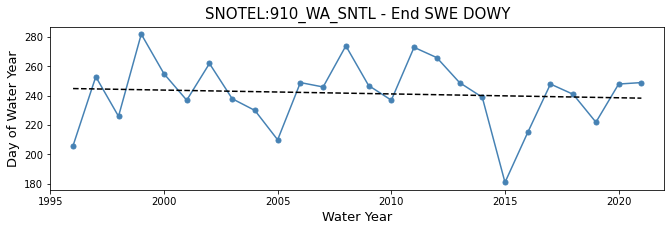

In [91]:
station = peak_910.columns[0]

x1 = np.linspace(x.min(),x.max(),2)
y1 = slope*x1 + intercept

f, ax = plt.subplots(figsize=(11,3))
plt.plot(x,y,'steelblue', linestyle='-', marker='.', markersize=10)
plt.plot(x1,y1,'k--')
plt.title(f'{station} - End SWE DOWY', fontsize=15, y=1.01)

plt.xlim(1995, 2022)

#plt.xticks(x)
plt.xlabel('Water Year', fontsize=13, labelpad=4)
plt.ylabel('Day of Water Year', fontsize=13, labelpad=4);

In [92]:
x = end_999.wy    # using x for shorthand below
y = end_999.dowy  # using y for shorthand below

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y)

print('B0 : {}'.format(np.round(intercept,4)))
print('B1 : {}'.format(np.round(slope,4)))

print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr : {}'.format(np.round(stderr,3)))

B0 : 3083.3333
B1 : -1.4
R^2 : 0.054
R : -0.232
stderr : 1.626


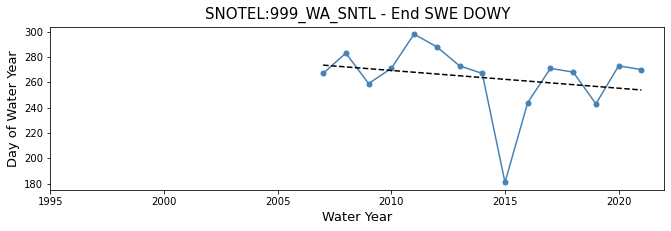

In [93]:
station = peak_999.columns[0]

x1 = np.linspace(x.min(),x.max(),2)
y1 = slope*x1 + intercept

f, ax = plt.subplots(figsize=(11,3))
plt.plot(x,y,'steelblue', linestyle='-', marker='.', markersize=10)
plt.plot(x1,y1,'k--')
plt.title(f'{station} - End SWE DOWY', fontsize=15, y=1.01)

plt.xlim(1995, 2022)

#plt.xticks(x)
plt.xlabel('Water Year', fontsize=13, labelpad=4)
plt.ylabel('Day of Water Year', fontsize=13, labelpad=4);

### Peak SWE Measurement Stats

In [94]:
x = peak.wy    # using x for shorthand below
y = peak.dowy  # using y for shorthand below

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y)

print('B0 : {}'.format(np.round(intercept,4)))
print('B1 : {}'.format(np.round(slope,4)))

print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr : {}'.format(np.round(stderr,3)))

B0 : 1616.6398
B1 : -0.6976
R^2 : 0.1
R : -0.316
stderr : 0.523


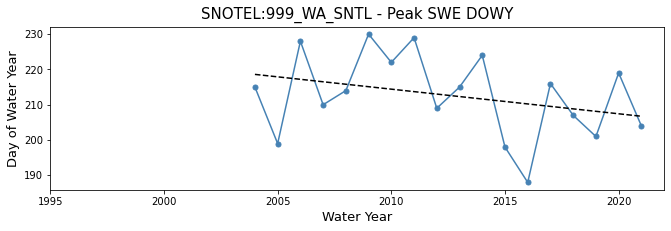

In [96]:
x1 = np.linspace(x.min(),x.max(),2)
y1 = slope*x1 + intercept

f, ax = plt.subplots(figsize=(11,3))
plt.plot(x,y, 'steelblue', linestyle='-', marker='.', markersize=10)
plt.plot(x1,y1,'k--')
plt.title(f'{station} - Peak SWE DOWY', fontsize=15, y=1.01)

plt.xlim(1995, 2022)

#plt.xticks(x)

plt.xlabel('Water Year', fontsize=13, labelpad=4)
plt.ylabel('Day of Water Year', fontsize=13, labelpad=4);

In [97]:
x = peak.wy    # using x for shorthand below
y = peak['SNOTEL:1011_WA_SNTL']  # using y for shorthand below

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y)

print('B0 : {}'.format(np.round(intercept,4)))
print('B1 : {}'.format(np.round(slope,4)))

print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr : {}'.format(np.round(stderr,3)))

B0 : -567.0242
B1 : 0.3157
R^2 : 0.007
R : 0.083
stderr : 0.952


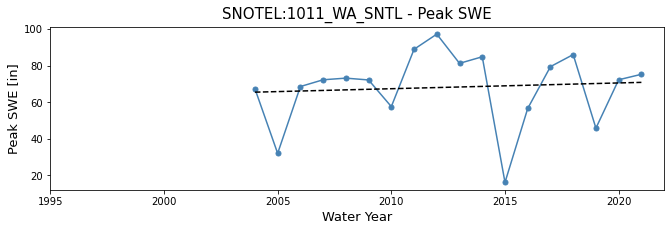

In [98]:
station = peak.columns[0]

x1 = np.linspace(x.min(),x.max(),2)
y1 = slope*x1 + intercept

f, ax = plt.subplots(figsize=(11,3))
plt.plot(x,y, 'steelblue', linestyle='-', marker='.', markersize=10)
plt.plot(x1,y1,'k--')
plt.title(f'{station} - Peak SWE', fontsize=15, y=1.01)

plt.xlim(1995, 2022)

#plt.xticks(x)

plt.xlabel('Water Year', fontsize=13, labelpad=4)
plt.ylabel('Peak SWE [in]', fontsize=13, labelpad=4);

In [99]:
x = peak_909.wy    # using x for shorthand below
y = peak_909['SNOTEL:909_WA_SNTL']  # using y for shorthand below

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y)

print('B0 : {}'.format(np.round(intercept,4)))
print('B1 : {}'.format(np.round(slope,4)))

print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr : {}'.format(np.round(stderr,3)))

B0 : -243.3152
B1 : 0.1389
R^2 : 0.008
R : 0.087
stderr : 0.325


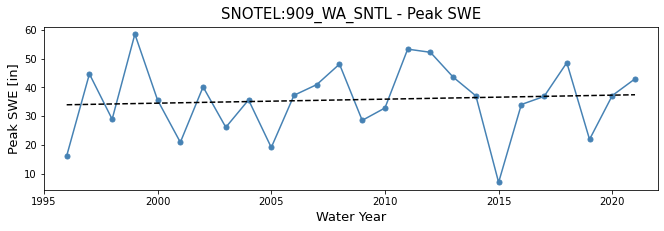

In [100]:
station = peak_909.columns[0]

x1 = np.linspace(x.min(),x.max(),2)
y1 = slope*x1 + intercept

f, ax = plt.subplots(figsize=(11,3))
plt.plot(x,y, 'steelblue', linestyle='-', marker='.', markersize=10)
plt.plot(x1,y1,'k--')
plt.title(f'{station} - Peak SWE', fontsize=15, y=1.01)

plt.xlim(1995, 2022)

#plt.xticks(x)

plt.xlabel('Water Year', fontsize=13, labelpad=4)
plt.ylabel('Peak SWE [in]', fontsize=13, labelpad=4);

In [101]:
x = peak_910.wy    # using x for shorthand below
y = peak_910['SNOTEL:910_WA_SNTL']  # using y for shorthand below

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y)

print('B0 : {}'.format(np.round(intercept,4)))
print('B1 : {}'.format(np.round(slope,4)))

print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr : {}'.format(np.round(stderr,3)))

B0 : 342.0905
B1 : -0.1505
R^2 : 0.004
R : -0.064
stderr : 0.477


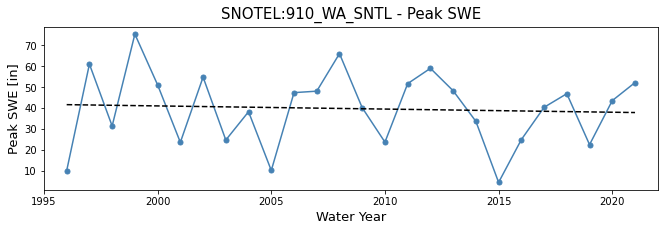

In [102]:
station = peak_910.columns[0]

x1 = np.linspace(x.min(),x.max(),2)
y1 = slope*x1 + intercept

f, ax = plt.subplots(figsize=(11,3))
plt.plot(x,y, 'steelblue', linestyle='-', marker='.', markersize=10)
plt.plot(x1,y1,'k--')
plt.title(f'{station} - Peak SWE', fontsize=15, y=1.01)

plt.xlim(1995, 2022)

#plt.xticks(x)

plt.xlabel('Water Year', fontsize=13, labelpad=4)
plt.ylabel('Peak SWE [in]', fontsize=13, labelpad=4);

In [103]:
x = peak_999.wy    # using x for shorthand below
y = peak_999['SNOTEL:999_WA_SNTL']  # using y for shorthand below

slope, intercept, rvalue, pvalue, stderr = stats.linregress(x, y)

print('B0 : {}'.format(np.round(intercept,4)))
print('B1 : {}'.format(np.round(slope,4)))

print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr : {}'.format(np.round(stderr,3)))

B0 : 3299.1752
B1 : -1.6057
R^2 : 0.106
R : -0.326
stderr : 1.294


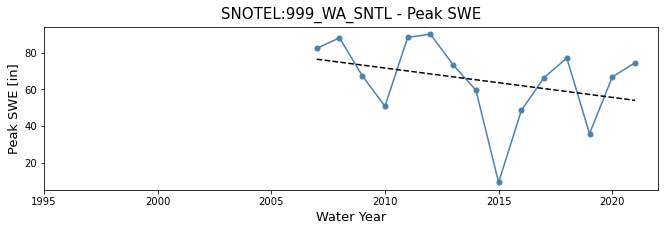

In [104]:
station = peak_999.columns[0]

x1 = np.linspace(x.min(),x.max(),2)
y1 = slope*x1 + intercept

f, ax = plt.subplots(figsize=(11,3))
plt.plot(x,y, 'steelblue', linestyle='-', marker='.', markersize=10)
plt.plot(x1,y1,'k--')
plt.title(f'{station} - Peak SWE', fontsize=15, y=1.01)

plt.xlim(1995, 2022)

#plt.xticks(x)

plt.xlabel('Water Year', fontsize=13, labelpad=4)
plt.ylabel('Peak SWE [in]', fontsize=13, labelpad=4);

In [111]:
start_north = start_1011.append(start_909)
start_south = start_910.append(start_999)

end_north = end_1011.append(end_909)
end_south = end_910.append(end_999)

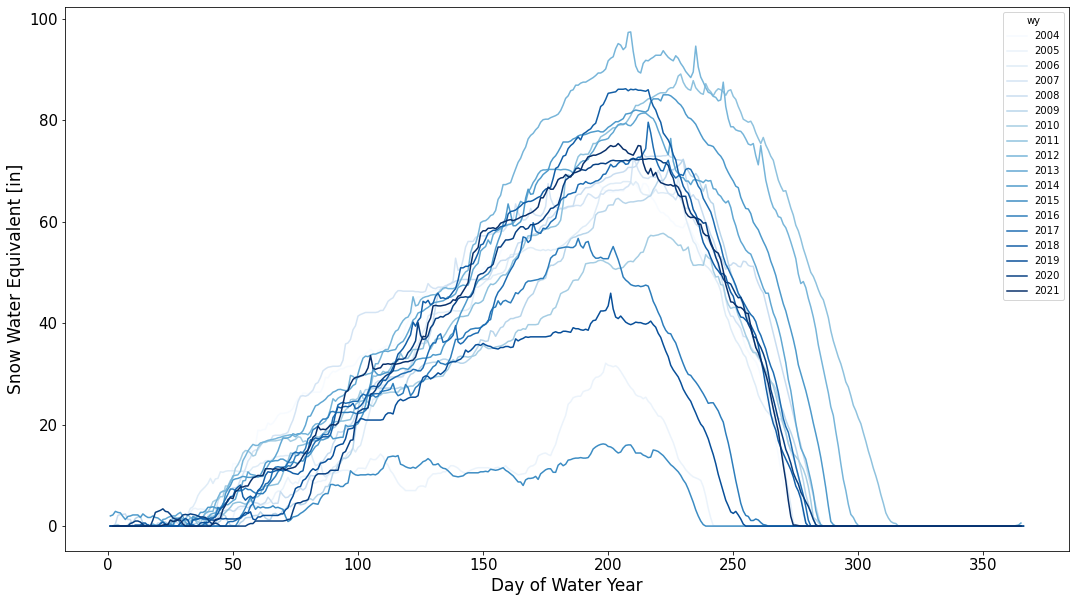

In [135]:
piv = pd.pivot_table(wteq_1011, index=('dowy'), columns=['wy'], values=wteq_1011.columns[0])

f, ax = plt.subplots(figsize=(18,10))
piv.plot(cmap='Blues', ax=ax)
#piv_909.plot(cmap='Reds', ax=ax)

plt.tick_params(labelsize=15)
plt.xlabel('Day of Water Year', fontsize=17, labelpad=4)
plt.ylabel('Snow Water Equivalent [in]', fontsize=17, labelpad=4);